Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Chris Abruzzo"
COLLABORATORS = ""

---

# Problem description

In the last assignment, we created fully connected neural networks to
solve the task of classifying whether a ship is present in a satellite photo.

This assignment will address the same task, but using Convolutional Neural Network layers.


## Goal:

In this notebook, you will need to create a model in `TensorFlow/Keras` *using Convolutional layers*  to classify satellite photos. 

- The features are images: 3 dimensional collection of pixels
  - 2 spatial dimensions
  - 1 dimension with 3 features for different parts of the color spectrum: Red, Green, Blue
- The labels are either 1 (ship is present) or 0 (ship is not present)

Unlike the model we created in the previous assignment (using Dense/Fully Connected layers)
we will retain *all three color channels* of the data rather than converting it to one channel gray scale.

There are two notebook files in this assignment:
- The one you are viewing now: First and only notebook you need to work on. 
    - Train your models here
    - There are cells that will save your models to a file
- **`Model_test.ipynb`**:
    - PLEASE IGNORE    


## Learning objectives
- Learn how to construct Neural Networks in a Keras Sequential model that uses Convolutional layer types.
- Appreciate how layer choices impact number of weights

# Import modules

In [2]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

## Import tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.4.1
Version 2, minor 4


# API for students

We have defined some utility routines in a file `helper.py`. There is a class named `Helper` in it.  

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

`helper = helper.Helper()`

- getData: Get a collection of labeled images, used as follows

  >`data, labels = helper.getData()`
- showData: Visualize labelled images, used as follows

  >`helper.showData(data, labels)`
- plot training results: Visualize training accuracy, loss and validation accuracy, loss

  >`helper.plotTrain(history, modelName)`, where history is the result of model training
- save model: save a model in `./models` directory

  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`
 


In [3]:
# Load the helper module
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.Helper()


# Get the data

The first step in our Recipe is Get the Data.

We have provided a utility method `getData` to simplify this for you

In [4]:
# Get the data
data, labels = helper.getData()
n_samples, width, height, channel = data.shape

print("Data shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))



Data shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


We will shuffle the examples before doing anything else.

This is usually a good idea
- Many datasets are naturally arranged in a *non-random* order, e.g., examples with the sample label grouped together
- You want to make sure that, when you split the examples into training and test examples, each split has a similar distribution of examples

In [5]:
# Shuffle the data
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek


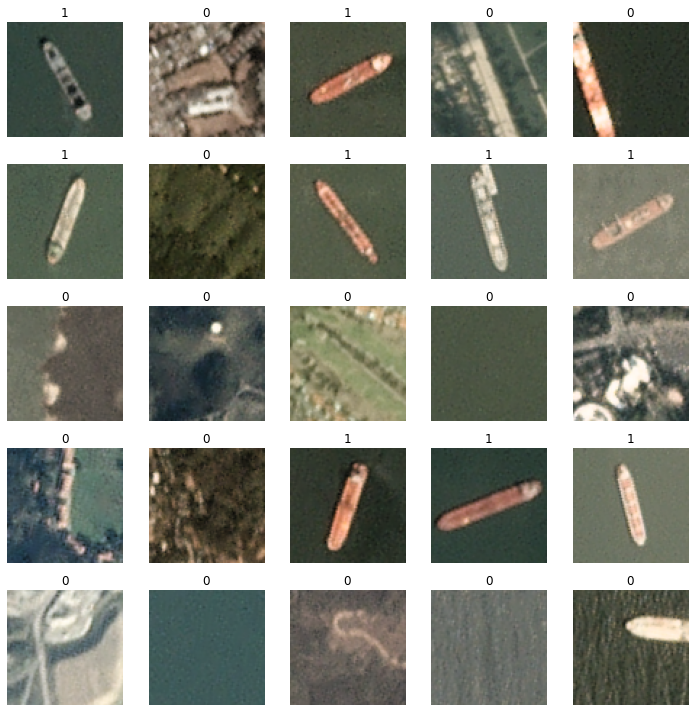

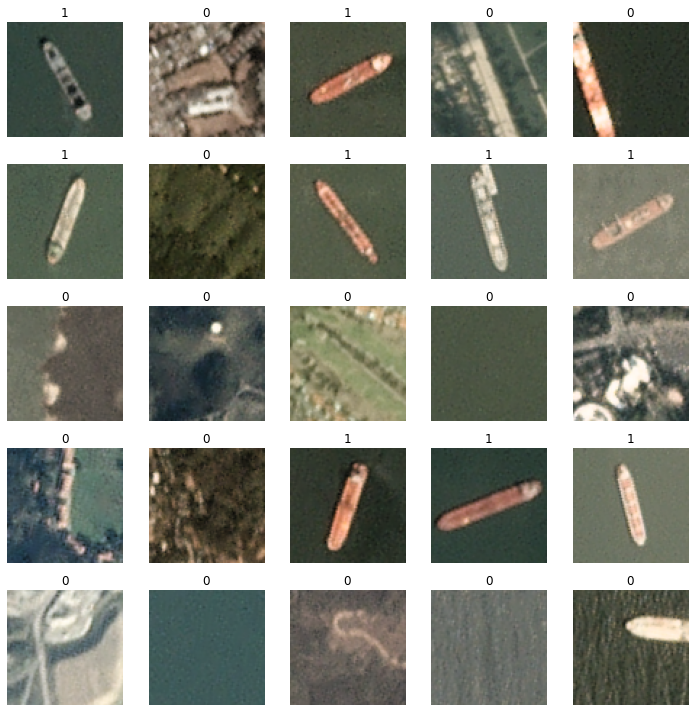

In [6]:
# Visualize the data samples
helper.showData(data[:25], labels[:25])


## Have  look at the data: Examine the image/label pairs

Rather than viewing the examples in random order, let's group them by label.

Perhaps we will learn something about the characteristics of images that contain ships.

We have loaded and shuffled our dataset, now we will take a look at image/label pairs. 

Feel free to explore the data using your own ideas and techniques.


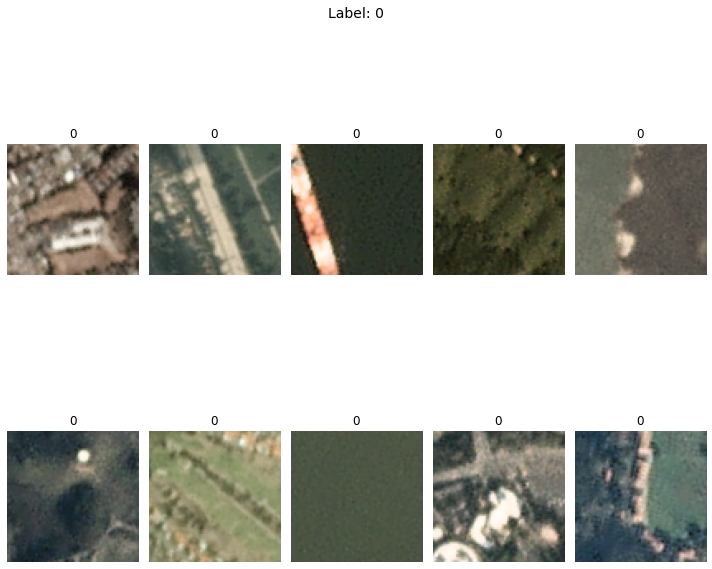

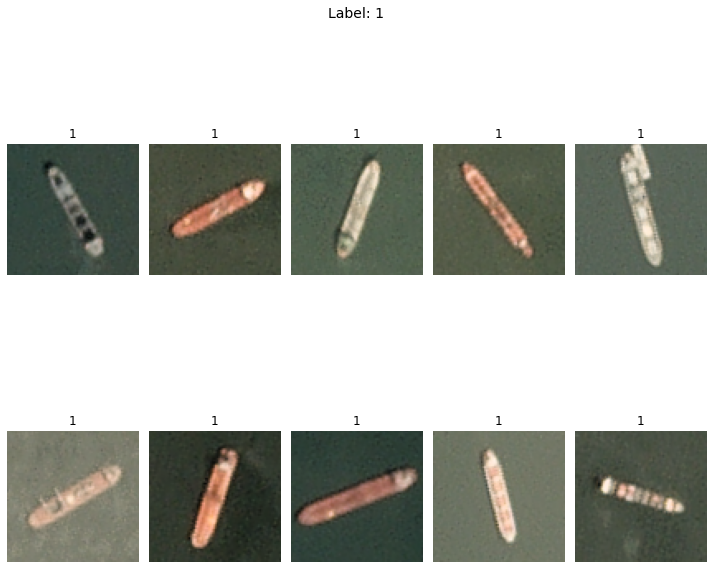

In [7]:
# Inspect some data (images)
num_each_label = 10

for lab in np.unique(labels):
    # Fetch images with different labels
    X_lab, y_lab = data[ labels == lab ], labels[ labels == lab]
    # Display images
    fig = helper.showData( X_lab[:num_each_label], [ str(label) for label in y_lab[:num_each_label] ], cmap="gray")
    _ = fig.suptitle("Label: "+  str(lab), fontsize=14)
    print("\n\n")


# Make sure the features are in the range [0,1]  

**Warm up exercise:** When we want to train on image data, the first thing we usually need to do is scaling. 

Since the feature values in our image data are between 0 and 255, to make them between 0 and 1, we need to divide them by 255.  

We also need to consider how to represent our target values
- If there are more than 2 possible target values, One Hot Encoding may be appropriate
    - **Hint**: Lookup `tf.keras.utils.to_categorical`
- If there are only 2 possible targets with values 0 and 1 we can use these targets without further encoding

**Question**
- Set variable `X` to be our examples (`data`), but with values in the range [0,1]
- Set variable `y` to be the representation of our target values



In [8]:
# Scale the data
# Assign values for X, y
#  X: the array of features
#  y: the array of labels
# The length of X and y should be identical and equal to the length of data.
from tensorflow.keras.utils import to_categorical
X, y = np.array([]), np.array([])

# YOUR CODE HERE
X = data/255
y = labels

In [9]:
# Check if your solution is right 

assert X.shape == (4000, 80, 80, 3)
assert ( (y.shape == (4000,)) or (y.shape == (4000,1)) )


# Split data into training data and testing data
To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell



In [10]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Save X_train, X_test, y_train, y_test for final testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/train_test_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)


# Create a simple CNN model 

**Question:** Create a Keras Sequential model:
- With a single Convolutional Layer providing the number of features given in variable `num_conv_features1` indicated below.
    - You may choose your own kernel size
    - Use full padding (also called "same padding") to make the spatial dimension of the input and output of a convolutional layer identical
- Feeding a head layer implementing Classification  

Please name your Convolutional layer "CNN_1" and your Dense layer (head layer) "dense_head"

Set variable `model0` to be a Keras `Sequential` model object that implements your model.

**Hints:**
1. The `input shape` argument of the first layer should be the shape of a single example, which should be 3-dimensional. We don't need to flatten the data before feeding the Convolutional layer.
2. What is the shape of the output of the Convolutional Layer ? What should be the shape of the input to the Classification head ?
    - You may want to flatten the output of the Convolutional layer before feeding the Classification head.
3. The number of units in your head layer 
    - Depends on how you represented the target
    - It should be equal to the final dimension of  `y`

4. Activation function for the head layer: Since this is a classification problem
    - Use  `sigmoid` if your target's final dimension equals 1
    - Use  `softmax` if your target's final dimension is greater than 1

Think about the number of parameters in this model and whether
it is likely to be prone to overfitting. 
If you feel the need:

- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`. 



In [11]:
# Set model0 equal to a Keras Sequential model
model0 = None

num_conv_features1 = 32

# YOUR CODE HERE
#import keras modules 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import initializers, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import SGD

#create Sequential object
model0 = Sequential()

#building stack of layers 
model0.add(Conv2D(num_conv_features1, kernel_size=(3,3), padding='same', input_shape=(80, 80, 3), activation='sigmoid',name='CNN_1'))
model0.add(Dropout(0.25))
model0.add(Flatten())
model0.add(Dense(1, activation='sigmoid',name='dense_head'))

model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 80, 80, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 204801    
Total params: 205,697
Trainable params: 205,697
Non-trainable params: 0
_________________________________________________________________


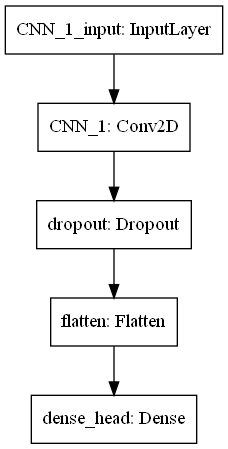

In [12]:
# Plot your model
plot_model(model0)

## Train model


**Question:**

Now that you have built your first model, you will compile and train it. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: 
    - `binary_crossentropy` if your target is one-dimensional
    - `categorical_crossentropy`if your target is One Hot Encoded
- Metric: "accuracy"
- Use the value in variable `max_epochs` as the number of epochs for training

- Plot your training results using the`plotTrain` method described in the Student API above.


Epoch 1/10
90/90 [==============================] - 23s 240ms/step - loss: 26.0957 - accuracy: 0.5971 - val_loss: 13.3073 - val_accuracy: 0.7472
Epoch 2/10
90/90 [==============================] - 19s 214ms/step - loss: 9.6475 - accuracy: 0.6447 - val_loss: 1.2376 - val_accuracy: 0.8181
Epoch 3/10
90/90 [==============================] - 18s 205ms/step - loss: 4.4086 - accuracy: 0.7067 - val_loss: 9.7303 - val_accuracy: 0.7472
Epoch 4/10
90/90 [==============================] - 19s 208ms/step - loss: 2.3774 - accuracy: 0.7841 - val_loss: 0.9333 - val_accuracy: 0.8250
Epoch 5/10
90/90 [==============================] - 19s 208ms/step - loss: 1.3326 - accuracy: 0.8005 - val_loss: 0.5817 - val_accuracy: 0.8750
Epoch 6/10
90/90 [==============================] - 19s 209ms/step - loss: 1.0716 - accuracy: 0.8094 - val_loss: 0.5171 - val_accuracy: 0.8597
Epoch 7/10
90/90 [==============================] - 18s 204ms/step - loss: 0.6201 - accuracy: 0.8323 - val_loss: 0.4771 - val_accuracy: 0.88

(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'CNN + Head model loss'}, xlabel='epoch', ylabel='loss'>,
        <AxesSubplot:title={'center':'CNN + Head model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

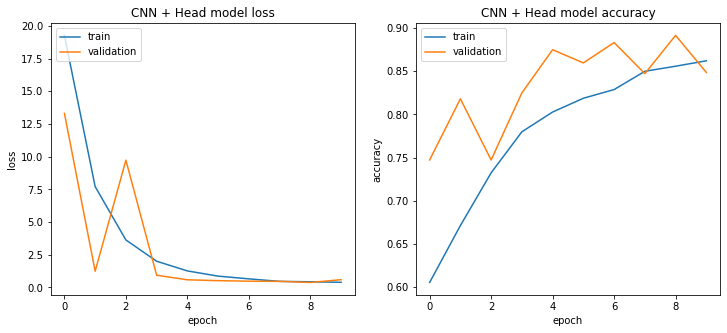

In [13]:
model_name0 = "CNN + Head"
max_epochs = 10

# YOUR CODE HERE
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

metrics_list = ['accuracy']

model0.compile(
            loss='binary_crossentropy',
            metrics= metrics_list
              )

history0 = model0.fit(X_train_2, y_train_2, epochs=max_epochs, validation_data = (X_test_2, y_test_2))

helper.plotTrain(history0, model_name0)

## How many weights in the model ?

**Question:** 

Calculate the number of parameters in your model.  

Set variable `num_parameters0` to be equal to the number of parameters in your model.

**Hint:** The model object may have a method to help you ! Remember that Jupyter can help you find the methods that an object implements.



In [14]:
# Set num_parameters2 equal to the number of weights in the model
num_parameters0 = None

# YOUR CODE HERE
num_parameters0 = model0.count_params()

print("Parameters number in model0: ", num_parameters0)

Parameters number in model0:  205697


## Evaluate the model

**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score0`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.




In [15]:
score0 = []

# YOUR CODE HERE
score0 = model0.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))

13/13 [==============================] - 0s 36ms/step - loss: 0.5112 - accuracy: 0.8525
CNN + Head: Test loss: 0.51 / Test accuracy: 0.85


Your test accuracy should be around 0.9

## Save the trained model0 and history for submission

Your fitted model can be saved for later use
- In general: so you can resume training at a later time
- In particular: to allow us to grade it !

Execute the following cell to save your model, which you will submit to us for grading.

In [16]:
helper.saveModel(model0, model_name0)
helper.saveHistory(history0, model_name0)

Directory .\models\CNN + Head already exists, files will be over-written.
Model saved in directory .\models\CNN + Head; create an archive of this directory and submit with your assignment.
Directory .\models\CNN + Head already exists, files will be over-written.


In [17]:
## Restore the model (make sure that it works)
model_loaded = helper.loadModel(model_name0)
score_loaded = model_loaded.evaluate(X_test, y_test, verbose=0)

assert score_loaded[0] == score0[0] and score_loaded[1] == score0[1]

# Create a model with 4 Convolutional layers

**Question:** 

We will now create a model with more Convolutional layers.
- Use **4** Convolutional layers.
    - You may choose your own kernel size
    - Use full padding
    - ReLU activation functions for the Convolutional layers

    - Each of the first two Convolutional layers should have the number of features given in variable `num_conv_features1` indicated below
        - Please name thee layers "CNN_1" and "CNN_2"
    - Each of the last two Convolutional layers should have the number of features given in variable `num_conv_features2` indicated below
        - Please name thee layers "CNN_3" and "CNN_4"
- Insert a `MaxPooling` layer after every two Convolutional layers (e.g., after CNN_2 and CNN_4)
    - to reduce each spatial dimension by a factor of 2  

- Please name your head layer "dense_head". 

Set variable `model1` to be a Keras `Sequential` model object that implements your model.

**Hints:**
- Don't forget to flatten the output of the layer feeding the Classification head 
- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 


In [18]:
# Set model1 equal to a Keras Sequential model
model1 = None
num_conv_features1 = 32
num_conv_features2 = 64

# YOUR CODE HERE
#Create sequential model object
model1 = Sequential()

#stack layers
model1.add(Conv2D(num_conv_features1, kernel_size = (3,3), padding='same', input_shape=(80, 80, 3), activation='relu', name= 'CNN_1'))
model1.add(Conv2D(num_conv_features1, kernel_size = (3,3), padding='same', activation='relu', name = 'CNN_2'))
model1.add(MaxPooling2D(pool_size=(2, 2))) 
model1.add(Conv2D(num_conv_features2, kernel_size = (3,3), padding='same', activation='relu', name = 'CNN_3'))
model1.add(Conv2D(num_conv_features2, kernel_size = (3,3), padding='same', activation='relu', name = 'CNN_4'))
model1.add(MaxPooling2D(pool_size=(2, 2))) 
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid', name = 'dense_head'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        18496     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 64)       

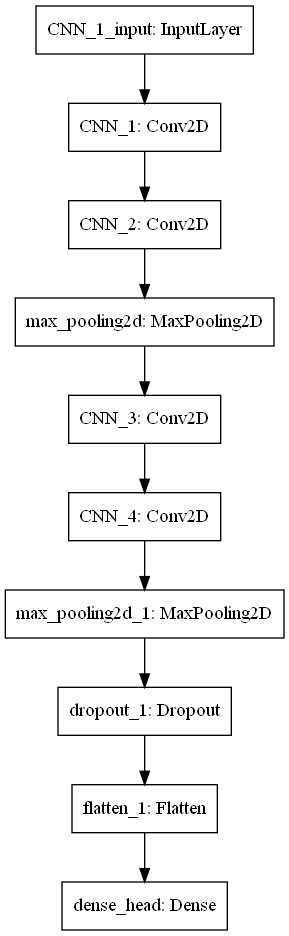

In [19]:
# Plot your model
plot_model(model1)

## Train model

**Question:**

Train your new model following the same instructions as given for training the first model.
- Use the same datasets for training and validation as in your first model
- Use the same Loss function and metrics as in your first model
- **Except**: Save your training results in a variable named `history1`



Epoch 1/10
90/90 [==============================] - 66s 713ms/step - loss: 0.5181 - accuracy: 0.7624 - val_loss: 0.3475 - val_accuracy: 0.8986
Epoch 2/10
90/90 [==============================] - 64s 709ms/step - loss: 0.2662 - accuracy: 0.8973 - val_loss: 0.1760 - val_accuracy: 0.9250
Epoch 3/10
90/90 [==============================] - 63s 705ms/step - loss: 0.1931 - accuracy: 0.9239 - val_loss: 0.2520 - val_accuracy: 0.8875
Epoch 4/10
90/90 [==============================] - 64s 708ms/step - loss: 0.1753 - accuracy: 0.9390 - val_loss: 0.1074 - val_accuracy: 0.9500
Epoch 5/10
90/90 [==============================] - 65s 726ms/step - loss: 0.1067 - accuracy: 0.9597 - val_loss: 0.1024 - val_accuracy: 0.9514
Epoch 6/10
90/90 [==============================] - 64s 714ms/step - loss: 0.0816 - accuracy: 0.9738 - val_loss: 0.0634 - val_accuracy: 0.9806
Epoch 7/10
90/90 [==============================] - 64s 712ms/step - loss: 0.0738 - accuracy: 0.9752 - val_loss: 0.1107 - val_accuracy: 0.9625

(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'4CNNs + Head model loss'}, xlabel='epoch', ylabel='loss'>,
        <AxesSubplot:title={'center':'4CNNs + Head model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

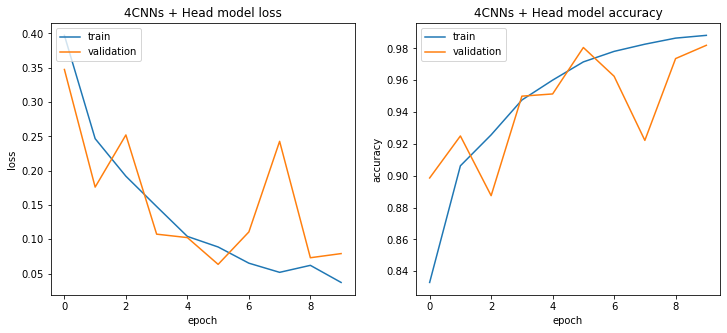

In [20]:
# Train the model using the API
model_name1 = "4CNNs + Head"

# YOUR CODE HERE
metrics_list = ['accuracy']

model1.compile(
            loss='binary_crossentropy',
            metrics= metrics_list
              )

history1 = model1.fit(X_train_2, y_train_2, epochs=max_epochs, validation_data = (X_test_2, y_test_2))

helper.plotTrain(history1, model_name1)

## How many weights in this model ?

**Question:** Calculate the number of parameters in your new model.  

Set variable `num_parameters1` to be equal to the number of parameters in your model.



In [21]:
# Set num_parameters3 equal to the number of weights in the model
num_parameters1 = None

# YOUR CODE HERE
num_parameters1 = model0.count_params()

print('Parameters number in model1:', num_parameters1)

Parameters number in model1: 205697


## Evaluate the model

Evaluate your new model following the same instructions as given for evaluating the first model.
- **Except**: store the model score in a variable named `score1`.  



In [22]:
score1 = []

# YOUR CODE HERE
score1 = model1.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name1, l=score1[0], a=score1[1]))

13/13 [==============================] - 3s 200ms/step - loss: 0.0606 - accuracy: 0.9825
4CNNs + Head: Test loss: 0.06 / Test accuracy: 0.98


Is your test accuracy higher than before ?

# Save your trained model1 and history1

In [23]:
helper.saveModel(model1, model_name1)
helper.saveHistory(history1, model_name1)

Directory .\models\4CNNs + Head already exists, files will be over-written.
Model saved in directory .\models\4CNNs + Head; create an archive of this directory and submit with your assignment.
Directory .\models\4CNNs + Head already exists, files will be over-written.


## Discussion


You can learn a lot by experimenting.  Some ideas to try:
- Change the kernel size in Convolutional layers
- Change the number of features of Convolutional layers
- Experiment with different pooling layers: `MaxPooling2D` and `AveragePooling2D`
- Change the activation function

Observe the effect of each change on the Loss and Accuracy.

Questions to consider:
- How did the number of parameters change between the two models ?
- How did the choice of layer types affect the number of parameters ?


## Base Model for exploration

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 51201     
Total params: 61,345
Trainable params: 61,345
Non-trainable params: 0
__________________________________________________

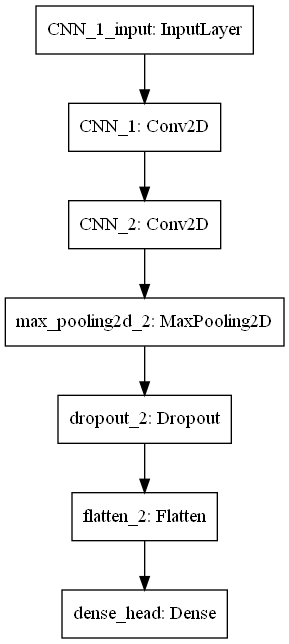

Epoch 1/8
90/90 [==============================] - 42s 453ms/step - loss: 1.4165 - accuracy: 0.6821 - val_loss: 0.5043 - val_accuracy: 0.7500
Epoch 2/8
90/90 [==============================] - 38s 424ms/step - loss: 0.4697 - accuracy: 0.7961 - val_loss: 0.3554 - val_accuracy: 0.8292
Epoch 3/8
90/90 [==============================] - 37s 409ms/step - loss: 0.3971 - accuracy: 0.8244 - val_loss: 0.3076 - val_accuracy: 0.8556
Epoch 4/8
90/90 [==============================] - 37s 406ms/step - loss: 0.3204 - accuracy: 0.8630 - val_loss: 0.2718 - val_accuracy: 0.8889
Epoch 5/8
90/90 [==============================] - 37s 410ms/step - loss: 0.2937 - accuracy: 0.8775 - val_loss: 0.2463 - val_accuracy: 0.8944
Epoch 6/8
90/90 [==============================] - 36s 405ms/step - loss: 0.2702 - accuracy: 0.8927 - val_loss: 0.2766 - val_accuracy: 0.8972
Epoch 7/8
90/90 [==============================] - 37s 411ms/step - loss: 0.2753 - accuracy: 0.8919 - val_loss: 0.2230 - val_accuracy: 0.9014
Epoch 

(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Base: 2 CNN + Head model loss'}, xlabel='epoch', ylabel='loss'>,
        <AxesSubplot:title={'center':'Base: 2 CNN + Head model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

13/13 [==============================] - 1s 106ms/step - loss: 0.2344 - accuracy: 0.8975
Base: 2 CNN + Head: Test loss: 0.23 / Test accuracy: 0.90


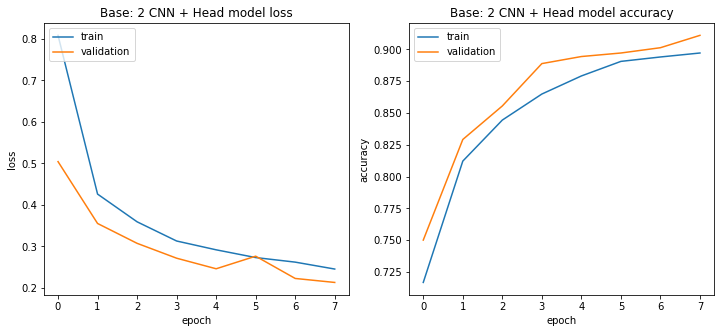

In [24]:
#create Sequential object
model2 = Sequential()

#building stack of layers 
model2.add(Conv2D(num_conv_features1, kernel_size=(3,3), padding='same', input_shape=(80, 80, 3), activation='sigmoid',name='CNN_1'))
model2.add(Conv2D(num_conv_features1, kernel_size = (3,3), padding='same', activation='relu', name = 'CNN_2'))
model2.add(MaxPooling2D(pool_size=(2, 2))) 
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid',name='dense_head'))

model2.summary()

#plot model 
plot_model(model2)

model_name2 = "Base: 2 CNN + Head"
max_epochs = 8

#train model
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

metrics_list = ['accuracy']

model2.compile(
            loss='binary_crossentropy',
            metrics= metrics_list
              )

history2 = model2.fit(X_train_2, y_train_2, epochs=max_epochs, validation_data = (X_test_2, y_test_2))

helper.plotTrain(history2, model_name2)

#evaluate model
score2 = []

# YOUR CODE HERE
score2 = model2.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name2, l=score2[0], a=score2[1]))

### Different Pooling Layers
First we'll see the impact of using different pooling layer 'AveragePooling2D'

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
average_pooling2d (AveragePo (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 51201     
Total params: 61,345
Trainable params: 61,345
Non-trainable params: 0
__________________________________________________

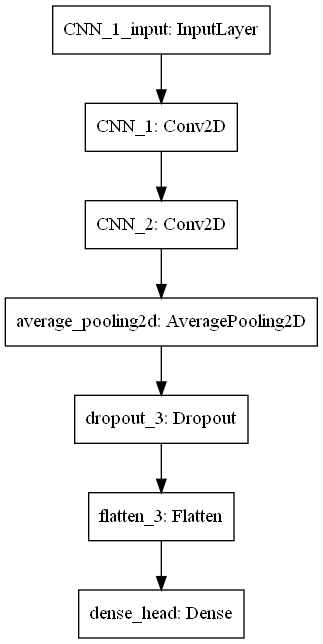

Epoch 1/8
90/90 [==============================] - 38s 409ms/step - loss: 1.6244 - accuracy: 0.6990 - val_loss: 0.5508 - val_accuracy: 0.7472
Epoch 2/8
90/90 [==============================] - 37s 407ms/step - loss: 0.5560 - accuracy: 0.7540 - val_loss: 0.3590 - val_accuracy: 0.8194
Epoch 3/8
90/90 [==============================] - 36s 405ms/step - loss: 0.3920 - accuracy: 0.8307 - val_loss: 0.3877 - val_accuracy: 0.8444
Epoch 4/8
90/90 [==============================] - 37s 406ms/step - loss: 0.3155 - accuracy: 0.8638 - val_loss: 0.2728 - val_accuracy: 0.8819
Epoch 5/8
90/90 [==============================] - 36s 403ms/step - loss: 0.2758 - accuracy: 0.8849 - val_loss: 0.3416 - val_accuracy: 0.8708
Epoch 6/8
90/90 [==============================] - 36s 405ms/step - loss: 0.2700 - accuracy: 0.8887 - val_loss: 0.2416 - val_accuracy: 0.9028
Epoch 7/8
90/90 [==============================] - 36s 401ms/step - loss: 0.2129 - accuracy: 0.9136 - val_loss: 0.2172 - val_accuracy: 0.8986
Epoch 

(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'AvePooling: 2 CNN + Head model loss'}, xlabel='epoch', ylabel='loss'>,
        <AxesSubplot:title={'center':'AvePooling: 2 CNN + Head model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

13/13 [==============================] - 2s 116ms/step - loss: 0.2172 - accuracy: 0.9200
AvePooling: 2 CNN + Head: Test loss: 0.22 / Test accuracy: 0.92


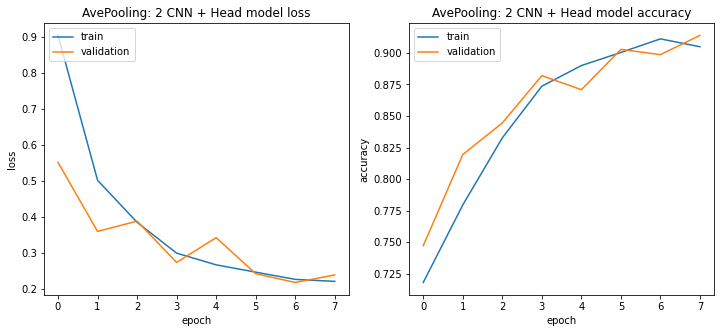

In [25]:
#import modules
from tensorflow.keras.layers import AveragePooling2D

#create Sequential object
model3 = Sequential()

#building stack of layers 
model3.add(Conv2D(num_conv_features1, kernel_size=(3,3), padding='same', input_shape=(80, 80, 3), activation='sigmoid',name='CNN_1'))
model3.add(Conv2D(num_conv_features1, kernel_size = (3,3), padding='same', activation='relu', name = 'CNN_2'))
model3.add(AveragePooling2D(pool_size=(2, 2))) 
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(1, activation='sigmoid',name='dense_head'))

model3.summary()

#plot model 
plot_model(model3)

model_name3 = "AvePooling: 2 CNN + Head"
max_epochs = 8

#train model
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

metrics_list = ['accuracy']

model3.compile(
            loss='binary_crossentropy',
            metrics= metrics_list
              )

history3 = model3.fit(X_train_2, y_train_2, epochs=max_epochs, validation_data = (X_test_2, y_test_2))

helper.plotTrain(history3, model_name3)

#evaluate model
score3 = []

# YOUR CODE HERE
score3 = model3.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name3, l=score3[0], a=score3[1]))

There was noticeable difference in performance for this model when changing the pooling layer from Maxpooling to Averagepooling.  Average pooling saw an increase of about 2%.

### Change kernel size in Convolutional layers
We will now evauluate the impact of changing the kernal size in convolutional layers.
- 'Utilizing the simple model for speed purposes'

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        2432      
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 51201     
Total params: 79,265
Trainable params: 79,265
Non-trainable params: 0
__________________________________________________

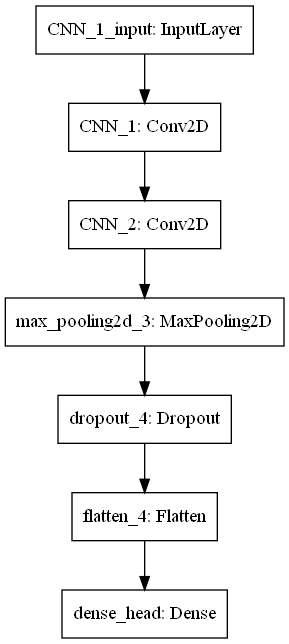

Epoch 1/8
90/90 [==============================] - 81s 888ms/step - loss: 2.7673 - accuracy: 0.6654 - val_loss: 0.5582 - val_accuracy: 0.7472
Epoch 2/8
90/90 [==============================] - 79s 871ms/step - loss: 0.5854 - accuracy: 0.7366 - val_loss: 0.4438 - val_accuracy: 0.7764
Epoch 3/8
90/90 [==============================] - 79s 880ms/step - loss: 0.4487 - accuracy: 0.8159 - val_loss: 0.3220 - val_accuracy: 0.8778
Epoch 4/8
90/90 [==============================] - 79s 876ms/step - loss: 0.3580 - accuracy: 0.8512 - val_loss: 0.2671 - val_accuracy: 0.8750
Epoch 5/8
90/90 [==============================] - 79s 879ms/step - loss: 0.3100 - accuracy: 0.8769 - val_loss: 0.2548 - val_accuracy: 0.8931
Epoch 6/8
90/90 [==============================] - 79s 880ms/step - loss: 0.2879 - accuracy: 0.8881 - val_loss: 0.2104 - val_accuracy: 0.9125
Epoch 7/8
90/90 [==============================] - 79s 877ms/step - loss: 0.2638 - accuracy: 0.8961 - val_loss: 0.2442 - val_accuracy: 0.8972
Epoch 

(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'New Kernel Size: 2 CNN + Head model loss'}, xlabel='epoch', ylabel='loss'>,
        <AxesSubplot:title={'center':'New Kernel Size: 2 CNN + Head model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

13/13 [==============================] - 3s 192ms/step - loss: 0.2015 - accuracy: 0.9050
New Kernel Size: 2 CNN + Head: Test loss: 0.20 / Test accuracy: 0.90


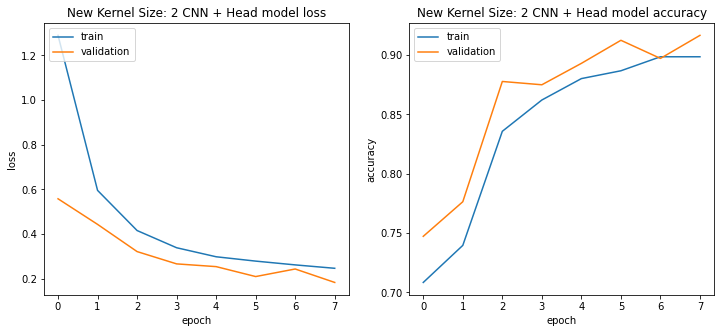

In [27]:
#create Sequential object
model4 = Sequential()

#building stack of layers 
model4.add(Conv2D(num_conv_features1, kernel_size=(5,5), padding='same', input_shape=(80, 80, 3), activation='sigmoid',name='CNN_1'))
model4.add(Conv2D(num_conv_features1, kernel_size = (5,5), padding='same', activation='relu', name = 'CNN_2'))
model4.add(MaxPooling2D(pool_size=(2, 2))) 
model4.add(Dropout(0.25))
model4.add(Flatten())
model4.add(Dense(1, activation='sigmoid',name='dense_head'))

model4.summary()

#plot model 
plot_model(model4)

model_name4 = "New Kernel Size: 2 CNN + Head"
max_epochs = 8

#train model
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

metrics_list = ['accuracy']

model4.compile(
            loss='binary_crossentropy',
            metrics= metrics_list
              )

history4 = model4.fit(X_train_2, y_train_2, epochs=max_epochs, validation_data = (X_test_2, y_test_2))

helper.plotTrain(history4, model_name4)

#evaluate model
score4 = []

# YOUR CODE HERE
score4 = model4.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name4, l=score4[0], a=score4[1]))

We don't see much improvement when increasing the kernal size.  
This was taxing on speed and computation power as well, taking almost 2 times as long to train.

In [28]:
print("Done")

Done
